# Overview: 

This notebook is created to do tasks given in the issue #3: [Traversal of the space of train/test splits](https://github.com/mozilla/PRESC/issues/3)




### Tasks: 

* Write a function that 
    - takes a scikit-learn estimator and a dataset.
    - computes an evaluation metric over a grid of train/test split proportions from 0 to 100%. 

* To assess variability, 
    - for each split proportion it should resplit and recompute the metric multiple times. 
    - It should output a table of splits with multiple metric values per split.


Here I will skip description of cells which i described in first notebook.

# The Purpose of Train/Test Sets


For creating a train and test split of dataset is one method to quickly evaluate the performance of an algorithm on a problem.

The training dataset is used to prepare a model, to train it.

We pretend the test dataset is new data where the output values are withheld from the algorithm. We gather predictions from the trained model on the inputs from the test dataset and compare them to the withheld output values of the test set.

Comparing the predictions and withheld outputs on the test dataset allows us to compute a performance measure for the model on the test dataset. This is an estimate of the skill of the algorithm trained on the problem when making predictions on unseen data.



## The use of Resampling Methods:

The problem with applied machine learning is that we are trying to model the unknown.

On a given predictive modeling problem, the ideal model is one that performs the best when making predictions on new data.

We don’t have new data, so we have to pretend with statistical tricks.

The train-test split and k-fold cross validation are called resampling methods. Resampling methods are statistical procedures for sampling a dataset and estimating an unknown quantity.

In the case of applied machine learning, we are interested in estimating the skill of a machine learning procedure on unseen data. More specifically, the skill of the predictions made by a machine learning procedure.

Once we have the estimated skill, we are finished with the resampling method.

- If you are using a train-test split, that means you can discard the split datasets and the trained model.
- If you are using k-fold cross-validation, that means you can throw away all of the trained models.


In [1]:
import pandas as panda
import numpy as np
from itertools import cycle
import matplotlib
import matplotlib.pylab as pylab
import seaborn as sns
import time

from sklearn import feature_selection, metrics
from sklearn import model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from sklearn.model_selection import learning_curve, train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, label_binarize
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import accuracy_score, mean_absolute_error, classification_report, confusion_matrix, f1_score, roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score, recall_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from matplotlib import pyplot as plot
import seaborn as sns

from scipy import interp

from numpy import bincount, linspace, mean, std, arange, squeeze

import itertools, time, datetime

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
matplotlib.style.use('ggplot')
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8

In other notebooks, I used  `pd.read_csv` fuction. Here using `remote_location` to get to familiar with this function.

In [2]:
remote_location = "../../datasets/defaults.csv"

Downloading the excel data from remote location. Reads one particular sheet, converts all columns names to lower case and then returns the data
    

In [3]:
def downLoadData():
    data = panda.read_csv(remote_location)
    data.rename(str.lower, inplace = True, axis = 'columns')
    print(data.dtypes)
    return data
data = downLoadData()

id           int64
limit_bal    int64
sex          int64
education    int64
marriage     int64
age          int64
pay_0        int64
pay_2        int64
pay_3        int64
pay_4        int64
pay_5        int64
pay_6        int64
bill_amt1    int64
bill_amt2    int64
bill_amt3    int64
bill_amt4    int64
bill_amt5    int64
bill_amt6    int64
pay_amt1     int64
pay_amt2     int64
pay_amt3     int64
pay_amt4     int64
pay_amt5     int64
pay_amt6     int64
defaulted    int64
dtype: object


In [4]:
data.shape

(30000, 25)

In [5]:
data.drop(['id'], inplace=True, axis =1) # droped the id column, since it adds no value other than row count
'id' not in data.columns.tolist()

True

Using F1 score to estimate our models, since F1 score is a better indicator of classification models when there is a bias in target classes

In [6]:
## dividing up x and y axis

_y_target = data['defaulted'].values

columns = data.columns.tolist()
columns.remove('defaulted')

_x_attributes = data[columns].values

## meaning of stratify = _y_target. returns test and training data having the same proportions of class label '_y_target'
_x_train,_x_test,_y_train, _y_test = train_test_split(_x_attributes, _y_target, test_size =0.30, stratify = _y_target, random_state = 1)

## Checking the distribution. train/test set distributed well
print("label counts in y train %s" %bincount(_y_train))
print("label counts in y test %s" %bincount(_y_test))

label counts in y train [16355  4645]
label counts in y test [7009 1991]


# Steps

The next steps would be to actually build out the model and compare metrics across all. In order to do so, we will take the following steps:

- splitting dataset into testing and training set

- create a list of classifiers

- create parameters for each of these classifiers. We will be using multiple possible parameters and let the alogrithm decide which is the best parameter providing the best score. eg for perceptron model, we will create 5-6 instances of learning rate and epoch values for parameter and model tuning

- create a pipeline from step 1 and 2. StandardScaling would be done across all.

- use gridsearch to perform parameter tuning for each model. Best parameters would be evaluated and we would be using the same parameters to predict values.

- plot learning curve using the above gridsearch instance so that we can compare our mean testing and training accuracy values and check for bias/variance

- Plot a bar chart for each model depicting f1 score, accuracy, training times, testing times. P.S: since our scores are within 0 and 1 , we are going to normalize our time metrics as well using min max method.

- Additionally display confusion matrix for each model.

- Write function to show table for different ratio of train/test split for `RandomForestClassifier`.

In [7]:
# Utility custom contextual class for calculating the time taken for a certain code block to execute
class CodeTimer:
    def __init__(self, name=None):
        self.name = " '"  + name + "'" if name else ''

    def __enter__(self):
        self.start = time.clock()

    def __exit__(self, exc_type, exc_value, traceback):
        self.took = (time.clock() - self.start) * 1000.0
        time_taken = datetime.timedelta(milliseconds = self.took)
        print('Code block' + self.name + ' took(HH:MM:SS): ' + str(time_taken))

In [8]:
# cv is essentially value of K in k fold cross validation 
# n_jobs = 1 is  non parallel execution    , -1 is all parallel , any other number say 2 means execute in 2 cpu cores

def plotLearningCurve(_x_train, _y_train, learning_model_pipeline,  k_fold = 10, training_sample_sizes = linspace(0.1,1.0,10), jobsInParallel = 1):
    
    training_size, training_score, testing_score = learning_curve(estimator = learning_model_pipeline, \
                                                                X = _x_train, \
                                                                y = _y_train, \
                                                                train_sizes = training_sample_sizes, \
                                                                cv = k_fold, \
                                                                n_jobs = jobsInParallel) 


    training_mean = mean(training_score, axis = 1)
    training_std_deviation = std(training_score, axis = 1)
    testing_std_deviation = std(testing_score, axis = 1)
    testing_mean = mean(testing_score, axis = 1 )

    ## we have got the estimator in this case the perceptron running in 10 fold validation with 
    ## equal division of sizes betwwen .1 and 1. After execution, we get the number of training sizes used, 
    ## the training scores for those sizes and the test scores for those sizes. we will plot a scatter plot 
    ## to see the accuracy results and check for bias vs variance

    # training_size : essentially 10 sets of say a1, a2, a3,,...a10 sizes (this comes from train_size parameter, here we have given linespace for equal distribution betwwen 0.1 and 1 for 10 such values)
    # training_score : training score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    # testing_score : testing score for the a1 samples, a2 samples...a10 samples, each samples run 10 times since cv value is 10
    ## the mean and std deviation for each are calculated simply to show ranges in the graph

    plot.plot(training_size, training_mean, label= "Training Data", marker= '+', color = 'blue', markersize = 8)
    plot.fill_between(training_size, training_mean+ training_std_deviation, training_mean-training_std_deviation, color='blue', alpha =0.12 )

    plot.plot(training_size, testing_mean, label= "Testing/Validation Data", marker= '*', color = 'green', markersize = 8)
    plot.fill_between(training_size, testing_mean+ training_std_deviation, testing_mean-training_std_deviation, color='green', alpha =0.14 )

    plot.title("Scoring of our training and testing data vs sample sizes")
    plot.xlabel("Number of Samples")
    plot.ylabel("Accuracy")
    plot.legend(loc= 'best')
    plot.show()

In [9]:
def runGridSearchAndPredict(pipeline, x_train, y_train, x_test, y_test, param_grid, n_jobs = 1, cv = 10, score = 'accuracy'):
    
    response = {}
    training_timer       = CodeTimer('training')
    testing_timer        = CodeTimer('testing')
    learning_curve_timer = CodeTimer('learning_curve')
    predict_proba_timer  = CodeTimer('predict_proba')
    
    with training_timer:
        gridsearch = GridSearchCV(estimator = pipeline, param_grid = param_grid, cv = cv, n_jobs = n_jobs, scoring = score)

        search = gridsearch.fit(x_train,y_train)

        print("Grid Search Best parameters ", search.best_params_)
        print("Grid Search Best score ", search.best_score_)
            
    with testing_timer:
        y_prediction = gridsearch.predict(x_test)
            
    print("Accuracy score %s" %accuracy_score(y_test,y_prediction))
    print("F1 score %s" %f1_score(y_test,y_prediction))
    print("Classification report  \n %s" %(classification_report(y_test, y_prediction)))
    
    with learning_curve_timer:
        plotLearningCurve(_x_train, _y_train, search.best_estimator_)
        
    with predict_proba_timer:
        if hasattr(gridsearch.best_estimator_, 'predict_proba'):
            
            y_probability = gridsearch.predict_proba(x_test)
            false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_probability[:,1])
            response['roc_auc_score'] = roc_auc_score(y_test, y_probability[:,1])
            response['roc_curve'] = (false_positive_rate, true_positive_rate)
    
        else: ## eg SVM, Perceptron doesnt have predict_proba method
            
            response['roc_auc_score'] = 0
            response['roc_curve'] = None
    
    response['learning_curve_time'] = learning_curve_timer.took
    response['testing_time'] = testing_timer.took
    response['_y_prediction'] = y_prediction
    response['accuracy_score'] = accuracy_score(y_test,y_prediction)
    response['training_time'] = training_timer.took
    response['f1_score']  = f1_score(y_test, y_prediction)
    
    
    return response
    

In [10]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plot.cm.Blues):

# This function prints and plots the confusion matrix. Normalization can be applied by setting `normalize=True`.
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plot.imshow(cm, interpolation='nearest', cmap=cmap)
    plot.title(title)
    plot.colorbar()
    tick_marks = arange(len(classes))
    plot.xticks(tick_marks, classes, rotation=45)
    plot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plot.ylabel('True label')
    plot.xlabel('Predicted label')
#     plot.tight_layout()
    plot.show()

# Machine learning models

We will create a list of classifiers and compare performance on different ratio of train/test split. The algorithms selected for classification are as below:

1. Perceptron
2. SVM
3. Logistic Regression
4. SVM Kernel RBF
5. DecisionTrees
6. RandomForest
7. Nearest Neighbour

In [11]:
classifiers = [
    Perceptron(random_state = 1),
    LogisticRegression(random_state = 1),
    DecisionTreeClassifier(random_state = 1, criterion = 'gini'),
    RandomForestClassifier(random_state = 1, criterion = 'gini'),
    KNeighborsClassifier(metric = 'minkowski'),
    SVC(random_state = 1, kernel = 'rbf'),    
]
classifier_names = [
            'perceptron',
            'logisticregression',
            'decisiontreeclassifier',
            'randomforestclassifier',
            'kneighborsclassifier',
            'svc',                   
]

classifier_param_grid = [
            
            {'perceptron__max_iter': [1,5,8,10], 'perceptron__eta0': [0.5,.4, .2, .1]},
            {'logisticregression__C':[100,200,300,50,20,600]},
            {'decisiontreeclassifier__max_depth':[6,7,8,9,10,11]},
            {'randomforestclassifier__n_estimators':[1,2,3,5,6]} ,
            {'kneighborsclassifier__n_neighbors':[4,6,7,8]},
            {'svc__C':[1], 'svc__gamma':[0.01]},   
]    

Grid Search Best parameters  {'perceptron__eta0': 0.5, 'perceptron__max_iter': 8}
Grid Search Best score  0.4342291772465281
Code block 'training' took(HH:MM:SS): 0:00:14.275958
Code block 'testing' took(HH:MM:SS): 0:00:00.004823
Accuracy score 0.5882222222222222
F1 score 0.2739028213166144
Classification report  
               precision    recall  f1-score   support

           0       0.78      0.66      0.71      7009
           1       0.22      0.35      0.27      1991

   micro avg       0.59      0.59      0.59      9000
   macro avg       0.50      0.50      0.49      9000
weighted avg       0.66      0.59      0.62      9000



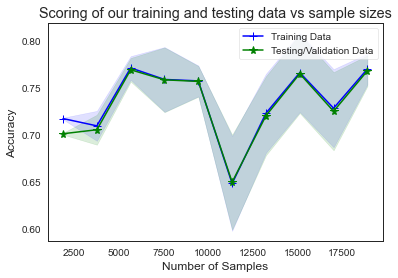

Code block 'learning_curve' took(HH:MM:SS): 0:00:05.046104
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000020
Grid Search Best parameters  {'logisticregression__C': 200}
Grid Search Best score  0.36182303543487687
Code block 'training' took(HH:MM:SS): 0:00:17.782648
Code block 'testing' took(HH:MM:SS): 0:00:00.004780
Accuracy score 0.811
F1 score 0.36506159014557676
Classification report  
               precision    recall  f1-score   support

           0       0.82      0.97      0.89      7009
           1       0.71      0.25      0.37      1991

   micro avg       0.81      0.81      0.81      9000
   macro avg       0.77      0.61      0.63      9000
weighted avg       0.80      0.81      0.77      9000



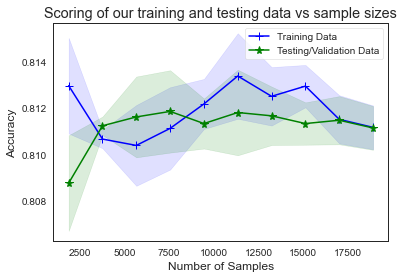

Code block 'learning_curve' took(HH:MM:SS): 0:00:14.584313
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.077613
Grid Search Best parameters  {'decisiontreeclassifier__max_depth': 7}
Grid Search Best score  0.4762641285827983
Code block 'training' took(HH:MM:SS): 0:00:17.972765
Code block 'testing' took(HH:MM:SS): 0:00:00.006946
Accuracy score 0.8131111111111111
F1 score 0.46569250317662003
Classification report  
               precision    recall  f1-score   support

           0       0.84      0.94      0.89      7009
           1       0.63      0.37      0.47      1991

   micro avg       0.81      0.81      0.81      9000
   macro avg       0.74      0.65      0.68      9000
weighted avg       0.79      0.81      0.79      9000



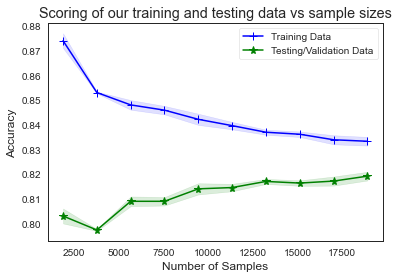

Code block 'learning_curve' took(HH:MM:SS): 0:00:15.190743
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.013441
Grid Search Best parameters  {'randomforestclassifier__n_estimators': 5}
Grid Search Best score  0.43656346166817483
Code block 'training' took(HH:MM:SS): 0:00:14.670262
Code block 'testing' took(HH:MM:SS): 0:00:00.018535
Accuracy score 0.7875555555555556
F1 score 0.42788749251944946
Classification report  
               precision    recall  f1-score   support

           0       0.83      0.91      0.87      7009
           1       0.53      0.36      0.43      1991

   micro avg       0.79      0.79      0.79      9000
   macro avg       0.68      0.63      0.65      9000
weighted avg       0.77      0.79      0.77      9000



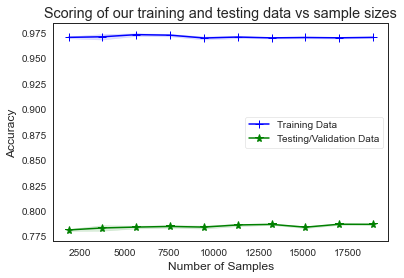

Code block 'learning_curve' took(HH:MM:SS): 0:00:20.051725
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.031028
Grid Search Best parameters  {'kneighborsclassifier__n_neighbors': 7}
Grid Search Best score  0.4266899847686028
Code block 'training' took(HH:MM:SS): 0:14:38.493642
Code block 'testing' took(HH:MM:SS): 0:00:10.783054
Accuracy score 0.8011111111111111
F1 score 0.4251766217084136
Classification report  
               precision    recall  f1-score   support

           0       0.83      0.93      0.88      7009
           1       0.59      0.33      0.43      1991

   micro avg       0.80      0.80      0.80      9000
   macro avg       0.71      0.63      0.65      9000
weighted avg       0.78      0.80      0.78      9000



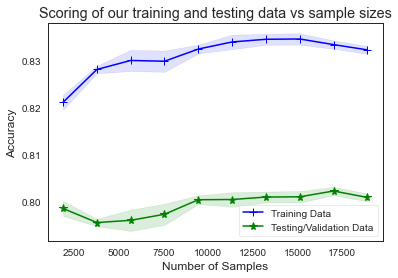

Code block 'learning_curve' took(HH:MM:SS): 0:15:52.254919
Code block 'predict_proba' took(HH:MM:SS): 0:00:12.863735
Grid Search Best parameters  {'svc__C': 1, 'svc__gamma': 0.01}
Grid Search Best score  0.4443066328723951
Code block 'training' took(HH:MM:SS): 0:05:08.488763
Code block 'testing' took(HH:MM:SS): 0:00:03.970763
Accuracy score 0.8172222222222222
F1 score 0.44142614601018676
Classification report  
               precision    recall  f1-score   support

           0       0.83      0.96      0.89      7009
           1       0.68      0.33      0.44      1991

   micro avg       0.82      0.82      0.82      9000
   macro avg       0.76      0.64      0.67      9000
weighted avg       0.80      0.82      0.79      9000



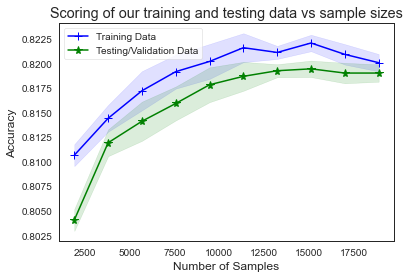

Code block 'learning_curve' took(HH:MM:SS): 0:18:02.797982
Code block 'predict_proba' took(HH:MM:SS): 0:00:00.000030
Code block 'overalltime' took(HH:MM:SS): 0:56:09.646074
3369646.0744000003


In [12]:
timer = CodeTimer(name='overalltime')
model_metrics = {}

with timer:
    for model, model_name, model_param_grid in zip(classifiers, classifier_names, classifier_param_grid):

        pipeline = Pipeline([
                ('scaler', StandardScaler()),
                (model_name, model)
        ])

        result = runGridSearchAndPredict(pipeline, _x_train, _y_train, _x_test, _y_test, model_param_grid , score = 'f1')

        _y_prediction = result['_y_prediction']

        _matrix = confusion_matrix(y_true = _y_test ,y_pred = _y_prediction)

        model_metrics[model_name] = {}
        model_metrics[model_name]['confusion_matrix'] = _matrix
        model_metrics[model_name]['training_time'] = result['training_time']
        model_metrics[model_name]['testing_time'] = result['testing_time']
        model_metrics[model_name]['learning_curve_time'] = result['learning_curve_time']
        model_metrics[model_name]['accuracy_score'] = result['accuracy_score']
        model_metrics[model_name]['f1_score'] = result['f1_score']
        model_metrics[model_name]['roc_auc_score'] = result['roc_auc_score']
        model_metrics[model_name]['roc_curve'] = result['roc_curve']
        
        
print(timer.took)

In [13]:
model_estimates = panda.DataFrame(model_metrics).transpose()

                       accuracy_score             confusion_matrix  f1_score  \
perceptron                   0.588222  [[4595, 2414], [1292, 699]]  0.273903   
logisticregression              0.811   [[6810, 199], [1502, 489]]  0.365062   
decisiontreeclassifier       0.813111   [[6585, 424], [1258, 733]]  0.465693   
randomforestclassifier       0.787556   [[6373, 636], [1276, 715]]  0.427887   
kneighborsclassifier         0.801111   [[6548, 461], [1329, 662]]  0.425177   
svc                          0.817222   [[6705, 304], [1341, 650]]  0.441426   

                        learning_curve_time  roc_auc_score  \
perceptron                         0.000000       0.000000   
logisticregression                 0.008850       0.722214   
decisiontreeclassifier             0.009413       0.748322   
randomforestclassifier             0.013923       0.702529   
kneighborsclassifier               0.878875       0.718577   
svc                                1.000000       0.000000   

    

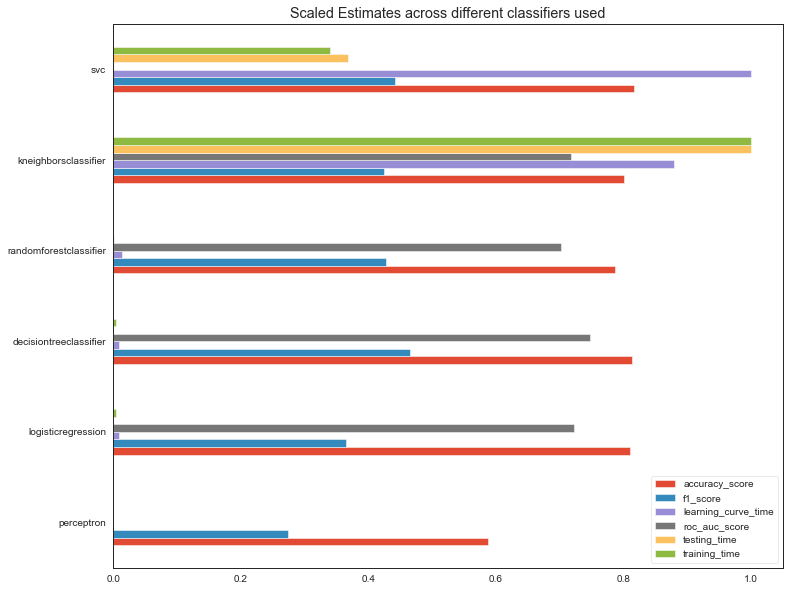

In [14]:
## convert model_metrics into panda data frame
## print out across model estimations and accuracy score bar chart


model_estimates['learning_curve_time'] = model_estimates['learning_curve_time'].astype('float64')
model_estimates['testing_time'] = model_estimates['testing_time'].astype('float64')
model_estimates['training_time'] = model_estimates['training_time'].astype('float64')
model_estimates['f1_score'] = model_estimates['f1_score'].astype('float64')
model_estimates['roc_auc_score'] = model_estimates['roc_auc_score'].astype('float64')

#scaling time parameters between 0 and 1
model_estimates['learning_curve_time'] = (model_estimates['learning_curve_time']- model_estimates['learning_curve_time'].min())/(model_estimates['learning_curve_time'].max()- model_estimates['learning_curve_time'].min())
model_estimates['testing_time'] = (model_estimates['testing_time']- model_estimates['testing_time'].min())/(model_estimates['testing_time'].max()- model_estimates['testing_time'].min())
model_estimates['training_time'] = (model_estimates['training_time']- model_estimates['training_time'].min())/(model_estimates['training_time'].max()- model_estimates['training_time'].min())

print(model_estimates)
model_estimates.plot(kind='barh',figsize=(12, 10))
plot.title("Scaled Estimates across different classifiers used")
plot.show()

In [15]:
def plotROCCurveAcrossModels(positive_rates_sequence, label_sequence):
    

    for plot_values, label_name in zip(positive_rates_sequence, label_sequence):
        
        plot.plot(list(plot_values[0]), list(plot_values[1]),  label = "ROC Curve for model: "+label_name)
        
    plot.plot([0, 1], [0, 1], 'k--', label = 'Random Guessing') #
    plot.title('ROC Curve across models')
    plot.xlabel('False Positive Rate')
    plot.ylabel('True Positive Rate')
    plot.legend(loc='best')
    plot.show()

Confusion matrix, without normalization
[[4595 2414]
 [1292  699]]


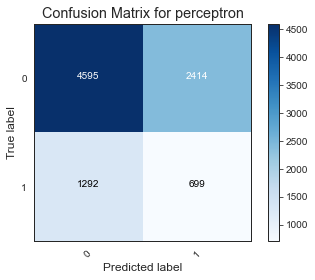

Confusion matrix, without normalization
[[6810  199]
 [1502  489]]


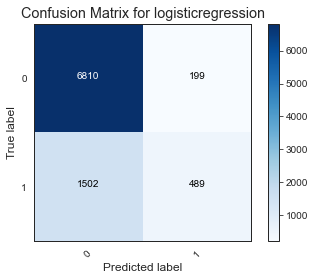

Confusion matrix, without normalization
[[6585  424]
 [1258  733]]


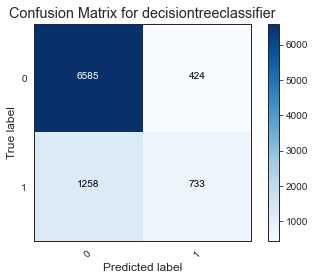

Confusion matrix, without normalization
[[6373  636]
 [1276  715]]


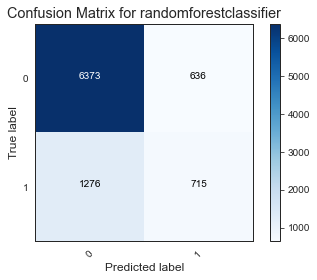

Confusion matrix, without normalization
[[6548  461]
 [1329  662]]


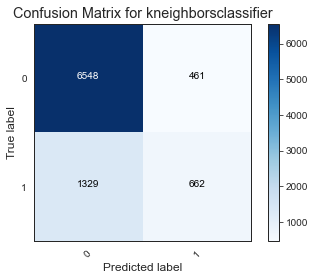

Confusion matrix, without normalization
[[6705  304]
 [1341  650]]


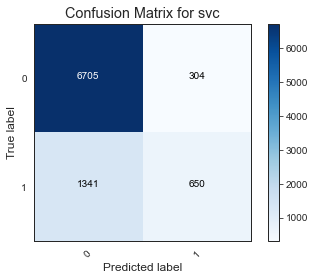

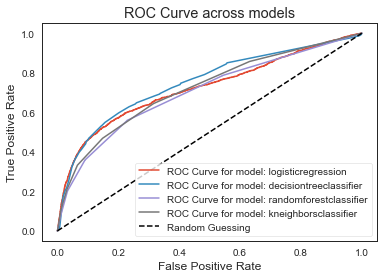

In [16]:
roc_curve_input = {}
for i , j in enumerate(model_metrics):
    
    _matrix = model_metrics[j]['confusion_matrix']
    plot_confusion_matrix(_matrix, classes = [0,1], title = 'Confusion Matrix for %s'%j)
    if model_metrics[j]['roc_curve']:
        roc_curve_input[j]= model_metrics[j]['roc_curve']
    

plotROCCurveAcrossModels(list(roc_curve_input.values()), list(roc_curve_input.keys()))

### Understanding:
- Perceptron model performed the worst, the accuracy and f1 scores both are very low. We can ignore perceptron model
- Logistic Regression performs better than perceptron with higher f1 score.
- SVM, K Nearest Neighbor, RandomForests all have pretty high f1 score. However their testing and training times are pretty high as well.
- If we look at the training vs testing curve for Nearest Neighbor and RandomForests, we see that there is a high variance. We can simply go ahead and ignore the models.
- SVM learning curve shows that at high number of samples, our training and testing data performs well. However, SVM has a very high training and testing time and F1 score is also pretty much comparable with the scores for DecisionTreeClassifier
- Based on our analysis above, we will select DecisionTreeClassifier as our model. The best parameters for the tree classifier is max depth of 6

# Conclusion

Based on our datasets, the model selected for best performance would be Decision Tree with a max depth of 7. These are the metrics we get for DecisionTreeClassifier:

accuracy score : 0.81

f1 score: 0.47

roc_auc_score : 0.75

training time: 29 secs

testing time: miniscule

In order to account for the unbalanced target classes, we are going to assign a class weight to our selected DEcisionTreeClassifier using the same best estimate. To check , if we are able to increase our F1 score and roc_auc_score.

Also, the goal of this notebook is checking different ratio for classifiers what is their accuracy. From graphs we can see in average, train/test ratio 80/20 gives the best result. 

In [17]:
classifier = DecisionTreeClassifier(random_state = 1, criterion = 'gini', max_depth = 7, class_weight = 'balanced')

pipeline = Pipeline([('scaler', StandardScaler()), ('decisiontreeclassifier', classifier)])

pipeline.fit(_x_train,_y_train)

y_prediction = pipeline.predict(_x_test)

y_probability = pipeline.predict_proba(_x_test)

print("Accuracy score accounting for unbalanced classes", accuracy_score(_y_test, y_prediction))
print("F1 score accounting for unbalanced classes", f1_score(_y_test, y_prediction))
print("ROC AUC score accounting for unbalanced classes", roc_auc_score(_y_test, y_probability[:, 1]))

Accuracy score accounting for unbalanced classes 0.7335555555555555
F1 score accounting for unbalanced classes 0.5039304923458833
ROC AUC score accounting for unbalanced classes 0.7449754097461979


# Matric

Now I will write function to show table for different ratio of train/test split for `RandomForestClassifier`.

In [18]:
data = data.rename(columns={'defaulted': 'def_pay','pay_0': 'pay_1'})

In [19]:
y = data['def_pay'].copy()

In [20]:
features = ['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6']
X = data[features].copy()
X.columns

Index(['limit_bal', 'sex', 'education', 'marriage', 'age', 'pay_1', 'pay_2',
       'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt1', 'bill_amt2',
       'bill_amt3', 'bill_amt4', 'bill_amt5', 'bill_amt6', 'pay_amt1',
       'pay_amt2', 'pay_amt3', 'pay_amt4', 'pay_amt5', 'pay_amt6'],
      dtype='object')

Here I have written a function which computes an evaluation metric over a grid of train/test split proportions from 0 to 90%. To assess variability, for each split proportion it resplits and recompute the metric multiple times. Also it will output a table of splits with multiple metric values per split.

In [21]:
#declearing column name for matric
metric_columns = [
    "Test Ratio",
    "Train Score",
    "Test Score",
    "Recall Score Macro",
    "f1 Score Macro"
]
metric_table = panda.DataFrame(columns=metric_columns)

In [22]:
# will use RandomForestClassifier for it
table_classifier_names = [
        ensemble.RandomForestClassifier(),      
       ]

In [23]:
#creating a table for different ratio of train/test split
def get_scores(start, end, interval, clf):
    result_list = []
    for i in range (start, end, interval): #spliting train/test ratio
        result_dict = {}
        test_ratio = i/100
        
        result_dict["Test Ratio"] = test_ratio
        
        train_X, test_X, train_y, test_y = model_selection.train_test_split(X, y, test_size=test_ratio, stratify=y, random_state=42)
        train_X = (train_X - train_X.mean())/train_X.std()
        test_X = (test_X - test_X.mean())/test_X.std()
        clf.fit(train_X,train_y)
        y_pred = clf.predict(test_X)
        result_dict["Recall Score Macro"] = recall_score(test_y, y_pred, average='macro')
        result_dict["f1 Score Macro"] = f1_score(test_y, y_pred, average='macro')
        result_dict["Train Score"] = clf.score(train_X, train_y)
        result_dict["Test Score"] = clf.score(test_X, test_y)
        result_list.append(result_dict)
    return result_list

In [24]:
def plot1_scores(metric, plot1, clf):
#        all_result_list = get_scores(1,10,1,clf)
        all_result_list = get_scores(10,100,10,clf)
#         all_result_list.extend(get_scores(10,100,10,clf))
#        all_result_list.extend(get_scores(91,100,1,clf))
        
        results = panda.DataFrame(all_result_list)
        print(clf.__class__.__name__)
        if(plot1):
            tr = results["Test Ratio"]
            ts = results[metric]
            plot.plot1(tr, ts)
            plot.xlabel('Test Ratio')
            plot.ylabel(metric)
            plot.show()
        else:
            display(clf)
            display(results)

In [25]:
plot1_scores("", False, ensemble.RandomForestClassifier())

RandomForestClassifier


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

,Recall Score Macro,Test Ratio,Test Score,Train Score,f1 Score Macro
0,0.606941,0.1,0.800000,0.981333,0.623516
1,0.620399,0.2,0.805000,0.979917,0.640003
2,0.624383,0.3,0.805889,0.979524,0.644598
3,0.623820,0.4,0.805917,0.978389,0.643990
4,0.619791,0.5,0.805400,0.982667,0.639418
5,0.616684,0.6,0.803278,0.978417,0.635455
6,0.615873,0.7,0.797952,0.981222,0.633416
7,0.617781,0.8,0.799875,0.976833,0.635940
8,0.622471,0.9,0.800852,0.981667,0.641246


Here I can see, the train/test ratio 80/20 gives the best result. This also happened for other classifiers if we look at the graphs. Thats why, in average we use 80/20 ratio for almost every model. 